# 示例代码

一些实际中碰到的例子：

## 例1

首先是一个shapefile有多个polygon组成，每个polygon代表一个流域，拆分成多个shapefile。

examples_data\bas_nonref_CntlPlains.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
           AREA  PERIMETER   GAGE_ID  \
0  1.209580e+08    81060.0  03144816   
1  3.458990e+08   158340.0  03145000   
2  2.573460e+07    38760.0  03156000   
3  2.288740e+08   115800.0  03157000   
4  1.194710e+09   290820.0  03157500   

                                            geometry  
0  POLYGON ((1123005.000 1972005.000, 1123035.000...  
1  POLYGON ((1123005.000 1972005.000, 1123035.000...  
2  POLYGON ((1130325.000 1933275.000, 1130325.000...  
3  POLYGON ((1123755.000 1919955.000, 1123725.000...  
4  POLYGON ((1123755.000 1919955.000, 1123725.000...  
Index(['AREA', 'PERIMETER', 'GAGE_ID', 'geometry'], dtype='object')


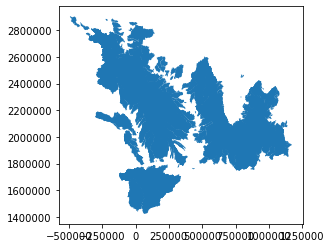

In [19]:
import os
import geopandas as gpd

# Define path to folder，以r开头表示相对路径
input_folder = r"examples_data"

# Join folder path and filename
fp = os.path.join(input_folder, "bas_nonref_CntlPlains.shp")

# Print out the full file path
print(fp)

# Read file using gpd.read_file()
data = gpd.read_file(fp)

print(type(data))
# 注意观察，geometry是一个由一系列坐标点组成的list，放入polygon的
print(data.head())
print(data.columns)

%matplotlib inline
data.plot()

先做坐标转换，首先看看现有数据的坐标系是什么，从上面的数据可以看出，坐标应该是m的形式，肯定是个投影坐标系。

In [25]:
from pyproj import CRS
print(data.crs)
# crs_proj4 = CRS(data.crs).to_proj4()
# print(crs_proj4)

{'proj': 'aea', 'lat_0': 23, 'lon_0': -96, 'lat_1': 29.5, 'lat_2': 45.5, 'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}


epsg:5070代表什么呢？在[epsg网站](https://epsg.io/)上查询，或直接谷歌或百度搜索。经查，在 https://epsg.io/5070-1252 网页上有说明，那现在想把它转为什么坐标呢，想转为下面要用的netcdf数据的坐标，因此这里暂停下，去下面看看netcdf数据的读取。然后查看下netcdf数据的坐标信息，这里先用一个[nad83下的Lambert等角圆锥投影](https://epsg.io/102009)到一个[wgs84下的横轴墨卡托投影](https://epsg.io/41001)的坐标变换做例子，为了验证是否正确，在https://epsg.io/ 网站上转一个点，然后和这里对照。

![](trans_coord.png)

In [28]:
from pyproj import Transformer
from pyproj import CRS, Proj, transform
import time

crs_from=CRS.from_proj4('+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
crs_to=CRS.from_proj4('+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
print(crs_from)
print(crs_to)
# print(crs_to.to_epsg())
# 定义transformer
transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
x_coord = 1427469.56401013
y_coord = 231871.42687957
start=time.time()
x1,y1 = transformer.transform(x_coord, y_coord)  
end=time.time()
print(x1)
print(y1)
print('%.7f' % (end-start))

#  接着转换x，y坐标为经纬度坐标 WGS84坐标
# outProj = Proj('epsg:4326')
# python3.7 下 定义proj的方式如下所示。更多内容可以参考：https://pyproj4.github.io/pyproj/stable/index.html
outProj = CRS.from_epsg(4326)
print(outProj)
x2,y2 = transform(crs_to,outProj,x1,y1)
print(x2)
print(y2)

+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
-8667612.35367563
4954170.578414324
0.0000000
epsg:4326
40.79460979159966
-77.86248654129997


![](trans_coord1.png)

下面例子中netcdf数据的坐标proj4信息是：+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs

因此，将shapefile文件的坐标转换到该坐标下即可继续后面的运算。先尝试下转换到该坐标系下的情况，然后再转到WGS84下看看对错。坐标是一样的，应该是对的

In [29]:
crs_final=CRS.from_proj4('+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
print(crs_final)
# 这应该是自定义的一种投影，没有epsg编号
print(crs_final.to_epsg())
transformer1 = Transformer.from_crs(crs_from, crs_final, always_xy=True)
x3,y3 = transformer1.transform(x_coord, y_coord)  
print(x3)
print(y3)
lon,lat = transform(crs_final,outProj,x3,y3)
print(lon)
print(lat)

# 再试一些点
x4= -4560250
y4= 4984000                         # 3090000
lon4,lat4 = transform(crs_final,outProj,x4,y4)
print(lon4,lat4)
x5= -4560250                 # 3252750
y5=  4983000                # 4984000
lon5,lat5 = transform(crs_final,outProj,x5,y5)
print(lon5,lat5)

+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
None
1762267.535784329
54546.4057676215
40.79460979159966
-77.86248654129997
58.527701348497665 156.37123798357752
58.52477921360861 156.38762505680887


再从经纬度转回投影坐标

In [30]:
y,x = transform(outProj,crs_final, lon,lat)
print(y,x)

1762267.5357843342 54546.40576760309


如果是shapefile，那么直接一个个地转换坐标是很慢的，所以看看能不能直接转换shapefile，找到了一个利用pandas dataframe的算法。以下代码参考：https://gis.stackexchange.com/a/327367/154364

In [31]:
import pandas as pd
from pyproj import Proj, transform
from pyproj import Transformer
import time
from pyproj import CRS

crs_from=CRS.from_proj4('+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
outProj = CRS.from_epsg(4326)
df = pd.DataFrame({'x': [1427469.56401013]*100000, 
                   'y': [231871.42687957]*100000})
print(type(df['x']))
start=time.time()
df['x2'], df['y2'] = transform(crs_from, outProj, df['x'].tolist(), df['y'].tolist())
end=time.time()
print('%.7f' % (end-start))
print(df['x2'])
print(df['y2'])

<class 'pandas.core.series.Series'>
0.2178726
0        40.79461
1        40.79461
2        40.79461
3        40.79461
4        40.79461
           ...   
99995    40.79461
99996    40.79461
99997    40.79461
99998    40.79461
99999    40.79461
Name: x2, Length: 100000, dtype: float64
0       -77.862487
1       -77.862487
2       -77.862487
3       -77.862487
4       -77.862487
           ...    
99995   -77.862487
99996   -77.862487
99997   -77.862487
99998   -77.862487
99999   -77.862487
Name: y2, Length: 100000, dtype: float64


换一个坐标系再试一次：

In [33]:
# outProj_another= Proj(init='epsg:4269')
outProj_another= CRS.from_epsg(4269)
df['x3'], df['y3'] = transform(outProj_another,outProj,  df['x2'].tolist(), df['y2'].tolist())
print(df['x3'])
print(df['y3'])

0        40.79461
1        40.79461
2        40.79461
3        40.79461
4        40.79461
           ...   
99995    40.79461
99996    40.79461
99997    40.79461
99998    40.79461
99999    40.79461
Name: x3, Length: 100000, dtype: float64
0       -77.862487
1       -77.862487
2       -77.862487
3       -77.862487
4       -77.862487
           ...    
99995   -77.862487
99996   -77.862487
99997   -77.862487
99998   -77.862487
99999   -77.862487
Name: y3, Length: 100000, dtype: float64


接下来就构建一个shapefile到shapefile的代码，首先读取shapefile，然后对每个polygon的每个坐标点进行坐标变换，然后再重新构建一个个的shapefile，以备后用。

然后再将shapefile分割成多个，在实际运行中可以不必写入shapefile，只是构建为独立的geodataframe。

In [34]:
from pyproj import CRS
# 索引和dataframe一致
print('第一行',data.iloc[0,:],'\n')
print('geometry: ',type(data.iloc[0,:]['geometry']),'\n')
print('exteriors: ',list(data.iloc[0,:]['geometry'].exterior.coords)[0:5],'\n')
print('interiors',list(data.iloc[0,:]['geometry'].interiors)[0:5],'\n')
print('边界：',list(data.iloc[0,:]['geometry'].boundary)[0:5],'\n')
newdata = gpd.GeoDataFrame()
# 要赋值到0位置上，否则就成为geoseries了
newdata.at[0, 'geometry']  = data.iloc[0,:]['geometry']
print(type(newdata.at[0, 'geometry'] ))
newdata.at[0, 'AREA'] = data.iloc[0,:]['AREA']
newdata.at[0, 'PERIMETER'] = data.iloc[0,:]['PERIMETER']
inte = data.iloc[0,:]['GAGE_ID']
print(newdata)
# Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
newdata.crs = CRS.from_epsg(4326).to_wkt()
print("\nWell-Known Text (WKT):\n",newdata.crs)
# def wirte_shpfile(selection):
#     #  每行直接索引出来的就不是Geodataframe数据了，所以要    
#     newdata = gpd.GeoDataFrame()
#     newdata['geometry'] = selection['geometry']
    
#     series.plot()
#     # Create a output path for the data
#     output_folder = r"L2_data/"
#     output_fp = os.path.join(output_folder, "Class_36200.shp")
#     # Write those rows into a new file (the default output file format is Shapefile)
#     selection.to_file(output_fp)
    
# shp_files = df.iloc[5,:].apply(wirte_shpfile, axis=1)

第一行 AREA                                               1.20958e+08
PERIMETER                                                81060
GAGE_ID                                               03144816
geometry     POLYGON ((1123005 1972005, 1123035 1972005, 11...
Name: 0, dtype: object 

geometry:  <class 'shapely.geometry.polygon.Polygon'> 

exteriors:  [(1123005.0, 1972005.0), (1123035.0, 1972005.0), (1123065.0, 1972005.0), (1123065.0, 1971975.0), (1123095.0, 1971975.0)] 

interiors [<shapely.geometry.polygon.LinearRing object at 0x0000025C78CC2F08>] 

边界： [<shapely.geometry.linestring.LineString object at 0x0000025C78CC3588>, <shapely.geometry.linestring.LineString object at 0x0000025C7B1B25C8>] 

<class 'shapely.geometry.polygon.Polygon'>
                                            geometry         AREA  PERIMETER
0  POLYGON ((1123005 1972005, 1123035 1972005, 11...  120958000.0    81060.0

Well-Known Text (WKT):
 GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",63781

## 例2

接下来一个例子是判断一个shapefile中的points都在另一个shapefile的哪些polygons中，然后要把每个polygon的编号放入在它其中的point属性中。使用的数据是GAGESII的站点shapefile和HUC4级的流域shape图。

In [4]:
import geopandas as gpd

points_file = "examples_data/gagesII_9322_sept30_2011.shp"
points = gpd.read_file(points_file)
print("Number of rows:",len(points))
points.head()

Number of rows: 9322


,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,HCDN_2009,ACTIVE09,FLYRS1900,FLYRS1950,FLYRS1990,geometry
0,01011000,"Allagash River near Allagash, Maine",Non-ref,NorthEast,3186.8440,01,47.069611,-69.079544,ME,None,yes,78.0,60.0,20.0,POINT (2027371.849 2964479.789)
1,01013500,"Fish River near Fort Kent, Maine",Ref,NorthEast,2252.6960,01,47.237394,-68.582642,ME,yes,yes,85.0,60.0,20.0,POINT (2058479.303 2992966.016)
2,01015800,"Aroostook River near Masardis, Maine",Non-ref,NorthEast,2313.7550,01,46.523003,-68.371764,ME,None,yes,51.0,51.0,19.0,POINT (2096533.991 2921785.543)
3,01016500,"MACHIAS RIVER NEAR ASHLAND, ME",Non-ref,NorthEast,847.7721,01,46.628311,-68.434792,ME,None,None,32.0,32.0,0.0,POINT (2088548.849 2931578.094)
4,01017000,"Aroostook River at Washburn, Maine",Non-ref,NorthEast,4278.9070,01,46.777294,-68.157194,ME,None,yes,79.0,60.0,20.0,POINT (2104213.711 2953507.477)


In [5]:
points.crs

{'proj': 'aea',
 'lat_0': 23,
 'lon_0': -96,
 'lat_1': 29.5,
 'lat_2': 45.5,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

因为这里是把点属于哪个HUC4流域的属性加进来，很多属性也用不到，所以可以去掉一部分。

In [6]:
# Subset columns
points = points[["STAID", "STANAME",'CLASS','AGGECOREGI','DRAIN_SQKM','HUC02','LAT_GAGE','LNG_GAGE','STATE','geometry']]
points.head()

,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,geometry
0,01011000,"Allagash River near Allagash, Maine",Non-ref,NorthEast,3186.8440,01,47.069611,-69.079544,ME,POINT (2027371.849 2964479.789)
1,01013500,"Fish River near Fort Kent, Maine",Ref,NorthEast,2252.6960,01,47.237394,-68.582642,ME,POINT (2058479.303 2992966.016)
2,01015800,"Aroostook River near Masardis, Maine",Non-ref,NorthEast,2313.7550,01,46.523003,-68.371764,ME,POINT (2096533.991 2921785.543)
3,01016500,"MACHIAS RIVER NEAR ASHLAND, ME",Non-ref,NorthEast,847.7721,01,46.628311,-68.434792,ME,POINT (2088548.849 2931578.094)
4,01017000,"Aroostook River at Washburn, Maine",Non-ref,NorthEast,4278.9070,01,46.777294,-68.157194,ME,POINT (2104213.711 2953507.477)


In [7]:
polygons_file = "examples_data/HUC4.shp"
polys = gpd.read_file(polygons_file)
#Check the data
print("Number of rows:",len(polys))
polys.head(5)

Number of rows: 223


,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,{2836BE66-8D09-4A23-819A-032ACFC07EC9},None,None,None,None,2012-06-11,0,44545954.0,180271.24,AK,1901,Southeast Alaska,57.947896,28.870353,"MULTIPOLYGON (((-138.05906 61.25548, -138.0569..."
1,2,{9F60218E-B1CA-4EAF-8931-CA52BDA34AB3},None,None,None,None,2012-06-11,0,65524952.0,265170.31,AK,1902,South Central Alaska,89.820883,43.854624,"MULTIPOLYGON (((-147.12113 63.62619, -147.1193..."
2,3,{385907E5-EED5-4B90-97A3-403EC8B96CF6},None,None,None,None,2012-06-11,0,81222880.0,328697.62,AK,1903,Southwest Alaska,154.283501,55.858380,"MULTIPOLYGON (((-152.03511 64.41507, -152.0325..."
3,4,{84E9AA98-74D8-49D9-BE79-A44C89A3EFCE},None,None,None,None,2012-06-11,0,50834280.0,205719.21,AK,1905,Northwest Alaska,71.800744,41.153359,"MULTIPOLYGON (((-166.16926 68.87117, -166.1683..."
4,5,{E510FB22-3CEC-4490-B6D4-1A2EF616217E},None,None,None,None,2012-06-11,0,59066087.0,239032.18,AK,1906,Arctic Alaska,74.176092,54.664269,"POLYGON ((-155.77282 71.28410, -155.77268 71.2..."


同样的，polygon的属性也不需要全部，取一部分

In [8]:
# Subset columns
polys = polys[["OBJECTID", "AREAACRES",'AREASQKM','STATES','HUC4','NAME','SHAPE_Leng','SHAPE_Area','geometry']]
polys.head()

,OBJECTID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,44545954.0,180271.24,AK,1901,Southeast Alaska,57.947896,28.870353,"MULTIPOLYGON (((-138.05906 61.25548, -138.0569..."
1,2,65524952.0,265170.31,AK,1902,South Central Alaska,89.820883,43.854624,"MULTIPOLYGON (((-147.12113 63.62619, -147.1193..."
2,3,81222880.0,328697.62,AK,1903,Southwest Alaska,154.283501,55.858380,"MULTIPOLYGON (((-152.03511 64.41507, -152.0325..."
3,4,50834280.0,205719.21,AK,1905,Northwest Alaska,71.800744,41.153359,"MULTIPOLYGON (((-166.16926 68.87117, -166.1683..."
4,5,59066087.0,239032.18,AK,1906,Arctic Alaska,74.176092,54.664269,"POLYGON ((-155.77282 71.28410, -155.77268 71.2..."


然后需要判断下两者的坐标系是否一样，如果不一样，先把点的坐标转换成和polygon的shapefile一样的。

In [9]:
points.crs

{'proj': 'aea',
 'lat_0': 23,
 'lon_0': -96,
 'lat_1': 29.5,
 'lat_2': 45.5,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': True}

In [10]:
polys.crs

{'init': 'epsg:4269'}

In [11]:
points.crs == polys.crs

False

经过检查，发现坐标系并不相同，因此，首先需要转换坐标系

In [12]:
points = points.to_crs(polys.crs)

E:\Programs\anaconda3\envs\hydroGIS\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [13]:
# Check the crs of address points
print(points.crs)

# Check the crs of population layer
print(polys.crs)

# Do they match now?
points.crs == polys.crs

{'init': 'epsg:4269'}
{'init': 'epsg:4269'}


True

现在CRS一样了，就可以进行空间连接了。通过使用gpd.sjoin()函数将polys的属性连接到points中。

In [14]:
# Make a spatial join
join = gpd.sjoin(points, polys, how="inner", op="within")
join.head()

,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,geometry,index_right,OBJECTID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area
0,01011000,"Allagash River near Allagash, Maine",Non-ref,NorthEast,3186.8440,01,47.069611,-69.079544,ME,POINT (-69.07954 47.06961),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585
1,01013500,"Fish River near Fort Kent, Maine",Ref,NorthEast,2252.6960,01,47.237394,-68.582642,ME,POINT (-68.58264 47.23739),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585
2,01015800,"Aroostook River near Masardis, Maine",Non-ref,NorthEast,2313.7550,01,46.523003,-68.371764,ME,POINT (-68.37176 46.52300),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585
3,01016500,"MACHIAS RIVER NEAR ASHLAND, ME",Non-ref,NorthEast,847.7721,01,46.628311,-68.434792,ME,POINT (-68.43479 46.62831),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585
4,01017000,"Aroostook River at Washburn, Maine",Non-ref,NorthEast,4278.9070,01,46.777294,-68.157194,ME,POINT (-68.15719 46.77729),27,28,9019483.0,36500.58,"CN,ME",0101,St. John,20.810573,4.303585


In [15]:
len(join)

9322

In [16]:
len(points)

9322

可视化一下，看看

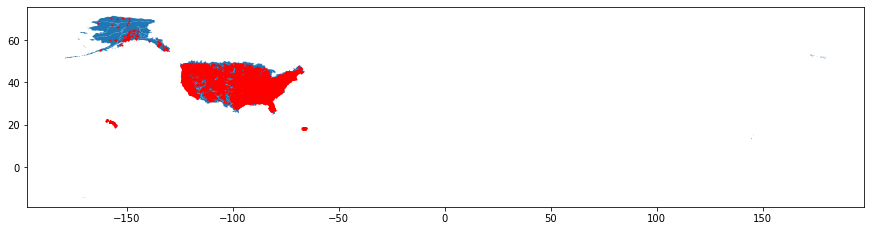

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(15,8))

# Plot population grid
polys.plot(ax=ax)

# Plot points
points.plot(ax=ax, color='red', markersize=1)

In [21]:
# Output path
outfp = r"examples_data/gagesII_9322_HUC4.shp"

# Save to disk
# join.to_file(outfp)

本地电脑上导出shpfile的时候proj总是没信息，可能是程序bug，可以卸载重新安装下geopandas等相关软件。